<a href="https://colab.research.google.com/github/brkbyrktr/Medical_Cost_Analysis/blob/main/Medical_Cost_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd  # Pandas kütüphanesi veri manipülasyonu için kullanılır.
import numpy as np  # NumPy kütüphanesi sayısal işlemler için kullanılır.
import seaborn as sns  # Seaborn kütüphanesi veri görselleştirmesi için kullanılır.
import matplotlib.pyplot as plt  # Matplotlib kütüphanesi grafik çizimi için kullanılır.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Makine öğrenimi modelini değerlendirmek ve ayarlamak için kullanılan araçlar.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler  # Veri ön işleme araçları.
from sklearn.linear_model import LinearRegression  # Doğrusal regresyon modeli.
from sklearn.tree import DecisionTreeRegressor  # Karar ağacı regresyon modeli.
from sklearn.ensemble import RandomForestRegressor  # Rastgele orman regresyon modeli.
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Hata metrikleri.

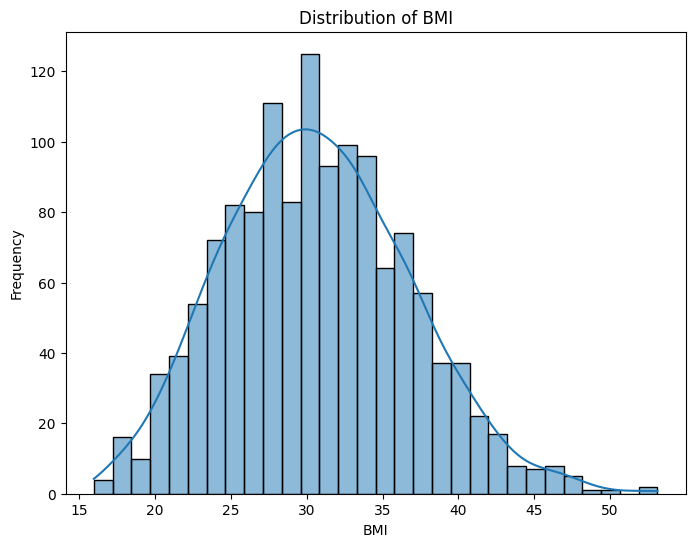

In [9]:
# Veri kümesini yükle
data = pd.read_csv("health_insurance_dataset.csv")

# BMI'nin dağılımını incele
plt.figure(figsize=(8, 6))  # Grafik boyutunu belirle
sns.histplot(data['bmi'], bins=30, kde=True)  # BMI değerlerinin histogramını çiz, 30 aralık kullan ve çekirdek yoğunluk tahmini ekle
plt.title("Distribution of BMI")  # Grafik başlığı
plt.xlabel("BMI")  # X ekseni etiketi
plt.ylabel("Frequency")  # Y ekseni etiketi
plt.show()  # Grafik göster

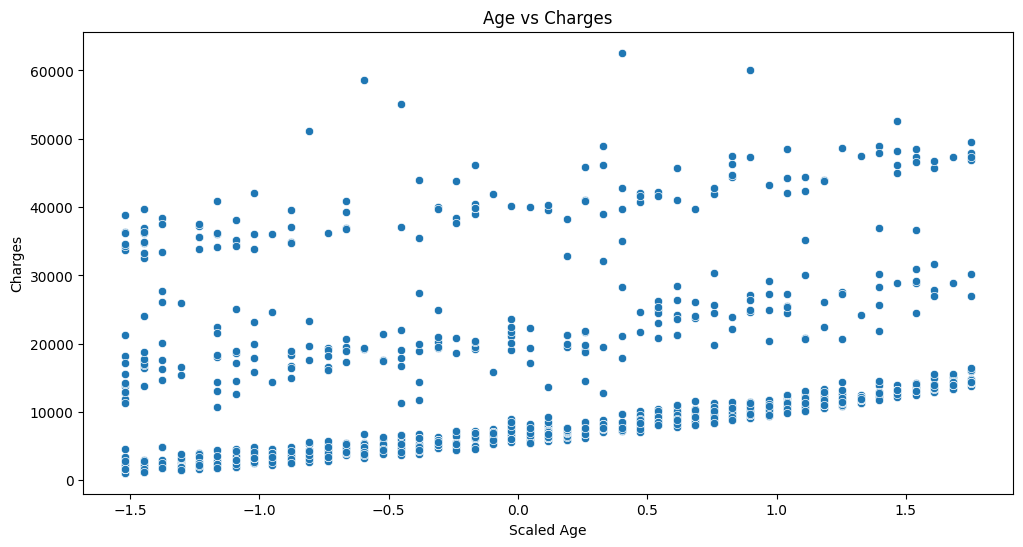

In [10]:
# Kategorik değişkenler için Etiket Kodlaması (Label Encoding) gerçekleştir
label_encoder = LabelEncoder()
data['sex'] = label_encoder.fit_transform(data['sex'])
data['smoker'] = label_encoder.fit_transform(data['smoker'])

# 'region' değişkeni için One-Hot Encoding gerçekleştir
data = pd.get_dummies(data, columns=['region'], drop_first=True)

# Veri kümesini özellikler (X) ve hedef (y) olarak ayır
X = data.drop('charges', axis=1)
y = data['charges']

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Veriyi Standart Ölçekleme kullanarak ölçeklendir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Veri Görselleştirmesi: Dağılım Grafiği
plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_train_scaled[:, 0], y=y_train)
plt.title("Age vs Charges")
plt.xlabel("Scaled Age")
plt.ylabel("Charges")
plt.show()

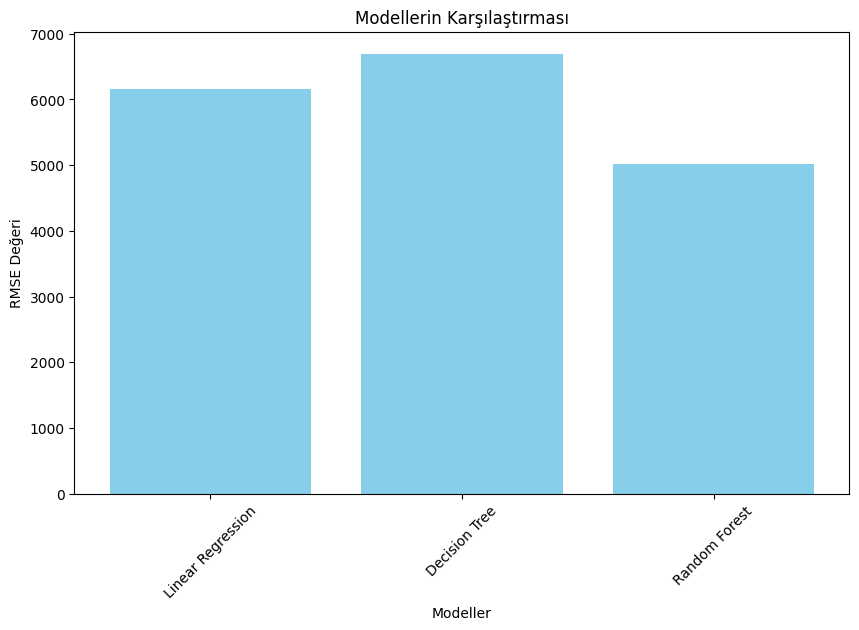

Linear Regression: RMSE = 6160.185958948655
Decision Tree: RMSE = 6698.116298293495
Random Forest: RMSE = 5024.8207761238145


In [13]:
# Modelleri başlat ve eğit
models = {
    'Linear Regression': LinearRegression(),  # Doğrusal Regresyon modeli
    'Decision Tree': DecisionTreeRegressor(),  # Karar Ağacı Regresyon modeli
    'Random Forest': RandomForestRegressor()  # Rastgele Orman Regresyon modeli
}

results = {}  # Sonuçları depolamak için bir sözlük oluştur

for name, model in models.items():  # Her model için döngü
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')  # Haç doğrulama ile modelin performansını değerlendir
    results[name] = np.sqrt(-scores.mean())  # Ortalama negatif hata karesinin karekökünü alarak RMSE hesapla

# Model performanslarını yazdır ve görselleştir
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.xlabel('Modeller')
plt.ylabel('RMSE Değeri')
plt.title('Modellerin Karşılaştırması')
plt.xticks(rotation=45)
plt.show()

# Model performanslarını yazdır
for name, score in results.items():  # Her model için performans sonucunu yazdır
    print(f'{name}: RMSE = {score}')  # Model adı ve RMSE değerini yazdır


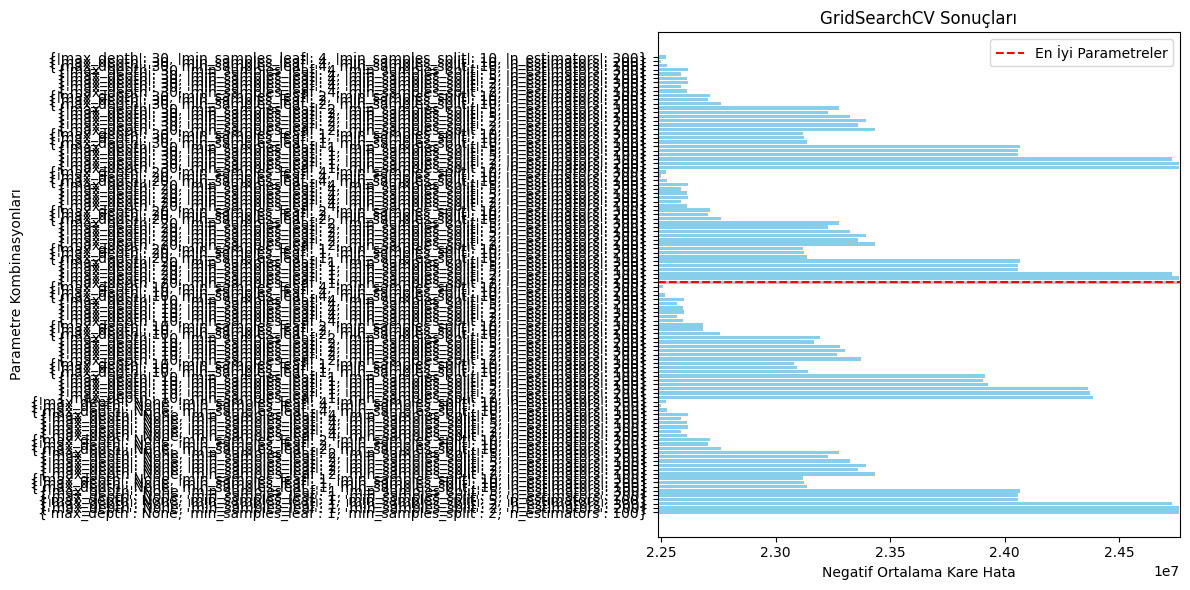

En iyi parametre kombinasyonu: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
En iyi negatif ortalama kare hata: 24765121.470819112
En iyi model: RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)


In [14]:
# Hyperparametre arama için kullanılacak parametre kombinasyonları
param_grid = {
    'n_estimators': [100, 200, 300],  # Karar ağaçlarının sayısı
    'max_depth': [None, 10, 20, 30],   # Karar ağacının maksimum derinliği
    'min_samples_split': [2, 5, 10],   # Bir düğümü bölmek için minimum örnek sayısı
    'min_samples_leaf': [1, 2, 4]      # Bir yaprak düğümü için minimum örnek sayısı
}

# Rastgele Orman Regresyon modeli oluştur
rf_model = RandomForestRegressor(random_state=42)

# GridSearchCV ile en iyi parametreleri ara
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# En iyi modeli seç
best_rf_model = grid_search.best_estimator_

# GridSearchCV sonuçlarını al
results = grid_search.cv_results_
params = results['params']
mean_scores = -results['mean_test_score']

# Parametre kombinasyonlarını düzenle
param_labels = [str(param) for param in params]

# Sonuçların görselleştirilmesi
plt.figure(figsize=(12, 6))
plt.barh(param_labels, mean_scores, color='skyblue')
plt.xlabel('Negatif Ortalama Kare Hata')
plt.ylabel('Parametre Kombinasyonları')
plt.title('GridSearchCV Sonuçları')
plt.xlim(np.min(mean_scores) - 1000, np.max(mean_scores) + 1000)
plt.tight_layout()

# En iyi parametre kombinasyonunu bul
best_params_idx = np.argmax(mean_scores)
best_params = param_labels[best_params_idx]
best_score = mean_scores[best_params_idx]

# En iyi parametre kombinasyonunu görselleştir
plt.axhline(y=best_params, color='r', linestyle='--', label='En İyi Parametreler')
plt.legend()

# Grafikleri göster
plt.show()

# En iyi modelin ve parametrelerin yazdırılması
print("En iyi parametre kombinasyonu:", best_params)
print("En iyi negatif ortalama kare hata:", best_score)
print("En iyi model:", best_rf_model)


Mean Squared Error: 19011410.546196193
Mean Absolute Error: 2478.7782954193353


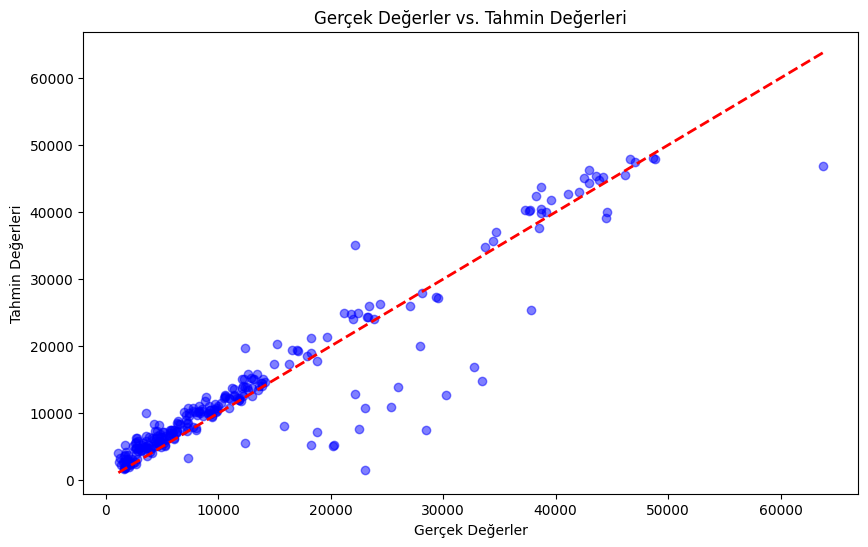

In [15]:
# Modelin test verileri üzerinde tahmin yapması
y_pred = best_rf_model.predict(X_test_scaled)

# Ortalama Kare Hatası (MSE) hesaplama ve yazdırma
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Ortalama Mutlak Hata (MAE) hesaplama ve yazdırma
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Tahminlerin gerçek değerlerle karşılaştırılması için çizgi grafiği oluşturma
plt.figure(figsize=(10, 6))

# Scatter plot çizimi: Gerçek değerler vs. Tahmin değerler
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# 45 derecelik kırmızı kesikli çizgi çizimi
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)

# Eksen etiketleri ve başlık eklemeleri
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Gerçek Değerler vs. Tahmin Değerleri')

# Grafiği görüntüleme
plt.show()
